# Dataset Generation

In [47]:
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Templates
we have 39 kinds of templates for 4 languages, but we only use 'de' and 'en' here for testing.

In [48]:
# templates
templates = pd.read_json("data/templates.json")
init_uttr_updated = pd.read_csv("data/InitUtterance_list_updated.csv")
templates_updated = templates.merge(init_uttr_updated, on='id')
templates_updated = templates_updated[['id', 'de', 'en']] #'fr', 'it',
templates_updated.head()

,id,de,en
0,MyCloud.OpenArea.Init.Utterance,{'texts': [{'ttsText': '{MyCloudArea} auf #myC...,{'texts': [{'ttsText': 'show {MyCloudArea} on ...
1,Router.SwitchOnWiFi.Init.Utterance,"{'texts': [{'ttsText': 'aktiviere das Wlan'}, ...","{'texts': [{'ttsText': 'activate the Wi-Fi'}, ..."
2,Tv.GenericExitToTv.Init.Utterance,{'texts': [{'ttsText': 'gehe zurück zum Fernse...,"{'texts': [{'ttsText': 'back to TV'}, {'ttsTex..."
3,Router.SwitchOffWiFi.Init.Utterance,{'texts': [{'ttsText': 'deaktiviere das Wlan'}...,{'texts': [{'ttsText': 'can you please switch ...
4,Tv.RadioChannelChange.Init.Utterance,{'texts': [{'ttsText': 'auf Radio {RadioChanne...,{'texts': [{'ttsText': 'can you turn on radio ...


In [49]:
templates_updated.describe()

,id,de,en
count,39,39,39
unique,39,39,39
top,Tv.NavigationLeft.Init.Utterance,{'texts': [{'ttsText': '{SmartHomeSceneName} S...,{'texts': [{'ttsText': 'activate {SmartHomeSce...
freq,1,1,1


## Entities
65K entities of 33 different types are included.
1/3 of them are from German environment.

In [50]:
# entities
entities = pd.read_json("data/entities.json")
entities = entities[['value', 'type', 'language', 'normalizedValue', 'aliases']]
entities.head()

,value,type,language,normalizedValue,aliases
0,Widnau,LocalsearchLocation,de,widnau,[]
1,Zurigo,LocalsearchLocation,it,zurigo,[]
2,Solothurn,LocalsearchLocation,de,solothurn,[]
3,Muttenz,LocalsearchLocation,de,muttenz,[]
4,Lyss,LocalsearchLocation,de,lyss,[]


In [51]:
entities.describe()


,value,type,language,normalizedValue,aliases
count,65471,65471,65471,65471,65471
unique,51272,33,4,52082,3793
top,Golf,SeriesName,de,golf,[]
freq,20,17913,22746,20,59649


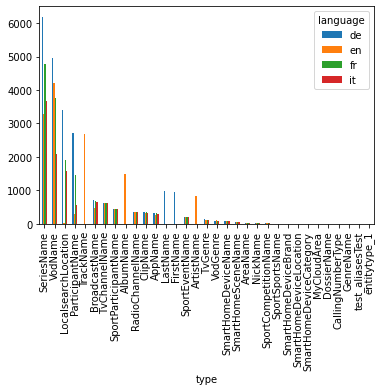

In [156]:
df = entities[['type', 'language']]
df = df.groupby(['type','language']).size().reset_index(name='count')
df2 = df.pivot(index='type', columns='language', values='count')
df2['sum'] = 0
df2 = df2.fillna(0)
for lang in ['de', 'en', 'fr', 'it',]:
    df2['sum'] += df2[lang]
# df.sort_values('count', ascending=False)
p = df2.sort_values('sum', ascending=False)[['de', 'en', 'fr', 'it']].plot(kind='bar')

### Find the representative

In [132]:
# TODO: deal with case "a"
from generator.tools import filter_aliases
sample_aliases1 = [
		"TF 3",         # value
        "TF three",     # normalized
		"T F 3",        # alias
		"t f three",    # alias
        "t f 3"         # alias
	]
filter_aliases(sample_aliases1,'en')

['TF 3']

In [53]:
sample_aliases2 = [
		"S R F",
        "s r f",
        "SRF",

        "SRF 1",
        "S R F 1",
		"s r f eins",
		"SRF eins",
        "SRF einz",
		"S R F einz",
        "S R F eis",
        "s r f eis",
		"s r f einz",
		"SRF eis",

		"SR",
		"s r",
        "S R",

		"D R S",
		"D R S 1",
		"DRS",
		"d r s",
        "DRS 1",
		"d r s eins",
		"DRS eins",

		"schweizer",
		"Schweizer",
        "Schweiz 1",
		"schweiz eins"
	]
filter_aliases(sample_aliases2, 'de')

['DRS',
 'SRF',
 'Schweiz 1',
 'SRF eis',
 'SR',
 'DRS 1',
 'SRF einz',
 'Schweizer',
 'SRF 1']

## Read custom dataset

In [92]:
# entities_custom
entities_custom = pd.read_json("data/entities_custom.json")
entities_updated = pd.concat([entities, entities_custom]).reset_index()
# update template
df = pd.read_json("data/timestamp_de_noted.json")
templates_updated.update(df)

df = pd.read_json("data/timestamp_en_noted.json")
templates_updated.update(df)

In [112]:
from generator.module import Generator
gen = Generator(templates=templates_updated, entities=entities_updated, method='one')

gen.get_command(target_id='SmartHome.SwitchOnDevice.Init.Utterance',
                target_lang='en',
                 verbose=True)

Choose template: 
	['please turn on {SmartHomeDeviceCategory} in the {SmartHomeDeviceLocation}']
After tag removal: 
	['please turn on cams in the powder room']


['please turn on cams in the powder room']

In [124]:
command_pool = []
sample_df = pd.DataFrame(columns=['de', 'en'], index=templates_updated.id)
for temp in templates_updated.id:
    for lang in ['en', 'de']:
        sample_df.loc[temp, lang] = gen.get_command(target_id=temp,
                                target_lang=lang,
                                 verbose=False)
sample_df

/Users/admin/Desktop/generator/generator/module.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return


,de,en
id,,
MyCloud.OpenArea.Init.Utterance,[auf myCloud zu meine Fotos gehen],[can you please open myCloud and open folders]
Router.SwitchOnWiFi.Init.Utterance,[das Wifi anlassen bitte],[I need to get into the internet]
Tv.GenericExitToTv.Init.Utterance,[Live Fernsehen bitte],[back to TV please]
Router.SwitchOffWiFi.Init.Utterance,[das Wlan aus],[please deactivate the Wi-Fi]
Tv.RadioChannelChange.Init.Utterance,[ich will Radiokanal 1 anhören],[I think this radio station is boring]
Router.ShowGuestWiFiPassword.Init.Utterance,[bitte Gast Wlan Passwort anzeigen],[could you give me the guest Wi-Fi password]
Tv.InitiateService.Init.Utterance,[tu die Box anstellen],[switch TV on]
Tv.OpenApplication.Init.Utterance,[bitte die App aufmachen],"[open No son tuits, son historias]"
SmartHome.SwitchOnDevice.Init.Utterance,[mach das Netatmo an],[turn my myStrom on]


In [133]:
# check a value
sample_df.loc['SmartHome.SwitchOnDevice.Init.Utterance', 'en']

['turn my myStrom on']

## Issue: LocalsearchTimeStampStart (Day/Time)

In [20]:
miss_id = ['Localsearch.TemperatureInfo.Init.Utterance' ,
            'Localsearch.RainInfo.Init.Utterance',
            'Localsearch.WeatherInfo.Init.Utterance' ]

k  = templates_updated[[t in miss_id for t in templates_updated.id]]
k[['id', 'de']].to_json("data/timestamp_de.json")
k[['id', 'en']].to_json("data/timestamp_en.json")



